# ML for PM & Trading
---
## Project Proposal: Study of the Links Between Gold Market and US Debt

### This project aims to explore the relationships between the gold market, US debt, and other macroeconomic data such as Federal Reserve (FED) rates using machine learning techniques. By analyzing historical data and applying various ML and Statistical models, we hope to uncover patterns and insights that can inform portfolio management and trading strategies.

- ``Authors`` : Paul-Antoine FRUCHTENREICH & Bilal BENHANA 
- ``Date`` : 2024

## API and package init

In [3]:
#pip install kagglehub
#pip install seaborn
#pip install statsmodels
#pip install imblearn

In [4]:
import requests
import time
import json
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import heatmap

import kagglehub
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, BaseCrossValidator, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, mean_absolute_percentage_error, r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score
from sklearn.decomposition import PCA, NMF
from functools import reduce

In [104]:
# Dictionary to map dataset IDs to their corresponding endpoints

dataset_endpoints = {
    'debt_to_penny': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/debt_to_penny',
    'average_interest_rate': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates',
    'tips_cpi': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/tips_cpi_data_detail'
}

def fetch_data(dataset_id, start_date, end_date, sort='record_date'):
    """
    Fetch data from the specified dataset endpoint with optional parameters.

    :param dataset_id: str, ID of the dataset to fetch (e.g., 'debt_to_penny', 'average_interest_rate', 'tips_cpi')
    :param start_date: str, start date for the data in 'YYYY-MM-DD' format
    :param end_date: str, end date for the data in 'YYYY-MM-DD' format
    :param sort: str, field to sort the data by (default is 'record_date')
    :return: dict, JSON response from the API
    """
    days = (datetime.datetime.strptime(end_date, '%Y-%m-%d') - datetime.datetime.strptime(start_date, '%Y-%m-%d')).days
    
    if days > 10000:
        raise ValueError(f"The maximum range of data that can be fetched is 10000 days (approximately 27 years). Here, the range is {days} days. (approximately {days//365} years).")

    if dataset_id not in dataset_endpoints:
        raise ValueError(f"Invalid dataset_id. Available options are: {list(dataset_endpoints.keys())}")

    url = dataset_endpoints[dataset_id]
    params = {
        'filter': f'{sort}:gte:{start_date},{sort}:lte:{end_date}',
        'sort': sort,
        'page[number]': 1,
        'page[size]': days
    }
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code} - {response.text}")

    df = pd.DataFrame(json.loads(response.text)['data'])
    return df

## Load gold prices and US debt data

### Load the gold price data into a DataFrame

In [6]:
# Download kaggle dataset of gold price from 1979 to 2022 on a daily basis
path = kagglehub.dataset_download("jishnukoliyadan/gold-price-1979-present")

# The gold with volume, open, high, low, close price  on a daily basis from 1994 to 2021
path_2 = kagglehub.dataset_download("nward7/gold-historical-datasets")

# The gold price in USD on a daily basis
gold_data = pd.read_csv(path + "/Daily_Gold_Price_on_World.csv")
gold_data_usd = gold_data[["Date", "US dollar (USD)"]]
gold_data_usd['Date'] = pd.to_datetime(gold_data_usd['Date'])
gold_data_usd = gold_data_usd.rename(columns={"US dollar (USD)": "usd_price"})
gold_data_usd = gold_data_usd.set_index('Date')
gold_data_2 = pd.read_csv(path_2 + "/Gold_Daily .csv")
gold_data_2['Date'] = pd.to_datetime(gold_data_2['Date'])
gold_data_2 = gold_data_2.rename(columns={"Change %": "Daily_return", "Vol":"Volume"})
gold_data_2 = gold_data_2.set_index('Date')
# convert the volume to numeric
gold_data_2["Volume"] = gold_data_2["Volume"].str.replace("K", "e3")
gold_data_2["Volume"] = pd.to_numeric(gold_data_2["Volume"], errors='coerce')
gold_data_2.dropna(inplace=True)

### Load US debt into a dataset

In [7]:
# Fetching US debt from 1993 to 2023
debt_to_penny_df_1 = fetch_data('debt_to_penny', '1993-01-01', '2003-01-01')
debt_to_penny_df_2 = fetch_data('debt_to_penny', '2003-01-01', '2023-01-01')
debt_to_penny_df = pd.concat([debt_to_penny_df_1, debt_to_penny_df_2])

# keep only the relevant columns
debt_to_penny_df = debt_to_penny_df[['record_date', 'tot_pub_debt_out_amt']]

# convert  tot_pub_debt_out_amt to numeric in trillions
debt_to_penny_df['record_date'] = pd.to_datetime(debt_to_penny_df['record_date'])
debt_to_penny_df['tot_pub_debt_out_amt'] = pd.to_numeric(debt_to_penny_df['tot_pub_debt_out_amt']) / 1e12  # convert to trillions $
debt_to_penny_df = debt_to_penny_df.set_index('record_date')


#### Periods of interest

In [8]:
# Define some periods of interest
decenal_periods = {
    '1993-2003': ('1993-01-01', '2003-01-01'),
    '2003-2013': ('2003-01-01', '2013-01-01'),
    '2013-2023': ('2013-01-01', '2023-01-01')
}

# Define all the crisis periods since 1993
crisis_periods = {
    '1997-1998 Asian Financial Crisis': ('1997-07-01', '1998-12-31'),
    '2000-2002 Dot-Com Bubble Burst': ('2000-03-01', '2002-12-31'),
    '2007-2008 Global Financial Crisis': ('2007-07-01', '2008-12-31'),
    '2010-2012 European Debt Crisis': ('2010-01-01', '2012-12-31'),
    '2015-2016 Chinese Stock Market Crash': ('2015-06-01', '2016-12-31'),
    '2019-2020 COVID-19 Pandemic': ('2019-12-01', '2020-12-31')
}

### Load US T-Notes Yields

In [9]:
path_3 = kagglehub.dataset_download("guillemservera/us-treasury-yields-daily")
us_bonds = pd.read_csv(path_3 + "/us_treasury_yields_daily.csv")
us_bonds["date"] = pd.to_datetime(us_bonds["date"])
us_bonds.set_index("date", inplace=True)
us_bonds

US1M  US3M  US6M  US1Y  US2Y  US3Y  US5Y  US7Y  US10Y  US20Y  \
date                                                                       
1962-01-02   NaN   NaN   NaN  3.22   NaN  3.70  3.88   NaN   4.06   4.07   
1962-01-03   NaN   NaN   NaN  3.24   NaN  3.70  3.87   NaN   4.03   4.07   
1962-01-04   NaN   NaN   NaN  3.24   NaN  3.69  3.86   NaN   3.99   4.06   
1962-01-05   NaN   NaN   NaN  3.26   NaN  3.71  3.89   NaN   4.02   4.07   
1962-01-08   NaN   NaN   NaN  3.31   NaN  3.71  3.91   NaN   4.03   4.08   
...          ...   ...   ...   ...   ...   ...   ...   ...    ...    ...   
2024-06-17  5.45  5.52  5.39  5.11  4.75  4.50  4.30  4.28   4.28   4.52   
2024-06-18  5.40  5.50  5.37  5.09  4.69  4.43  4.24  4.22   4.22   4.47   
2024-06-19   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   
2024-06-20  5.42  5.50  5.37  5.10  4.70  4.45  4.26  4.25   4.25   4.49   
2024-06-21  5.42  5.49  5.36  5.10  4.70  4.45  4.26  4.25   4.25   4.49   

            US30Y  
date               
1962-01-02    NaN  
1962-01-03    NaN  
1962-01-04    NaN  
1962-01-05    NaN  
1962-01-08    NaN  
...           ...  
2024-06-17   4.40  
2024-06-18   4.36  
2024-06-19    NaN  
2024-06-20   4.39  
2024-06-21   4.39  

[16299 rows x 11 columns]

### Features Engineering

In [10]:
# compute daily returns
gold_data_usd['daily_return'] = gold_data_usd['usd_price'].pct_change()
debt_to_penny_df['daily_return'] = debt_to_penny_df['tot_pub_debt_out_amt'].pct_change()

# compute daily variation
gold_data_usd['daily_variation'] = gold_data_usd['usd_price'].diff()
debt_to_penny_df['daily_variation'] = debt_to_penny_df['tot_pub_debt_out_amt'].diff()

# compute 7d - 28d - 90d - 365 annualized volatility for gold and debt
gold_data_usd['volatility_7d'] = gold_data_usd['daily_return'].rolling(window=7).std() * ((365/7)**0.5)
gold_data_usd['volatility_28d'] = gold_data_usd['daily_return'].rolling(window=28).std() * ((365/28)**0.5)
gold_data_usd['volatility_90d'] = gold_data_usd['daily_return'].rolling(window=90).std() * ((365/90)**0.5)
gold_data_usd['volatility_365d'] = gold_data_usd['daily_return'].rolling(window=365).std()



## Plots

### Gold Price

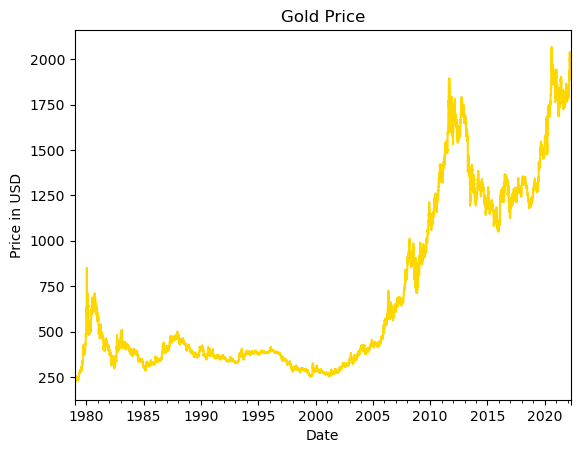

In [188]:
gold_data_usd['usd_price'].plot(color='gold')
plt.title('Gold Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()

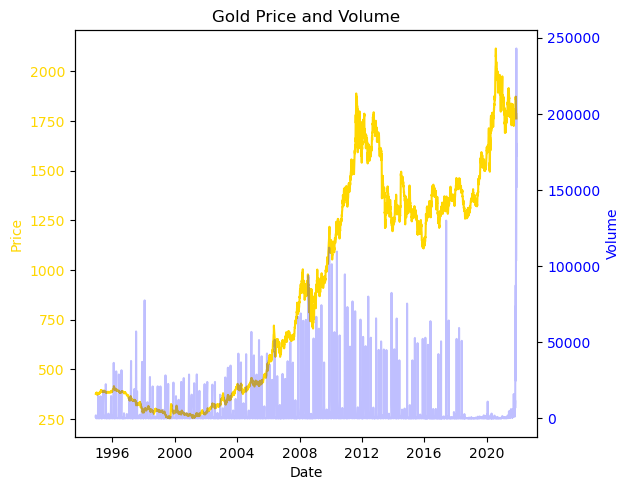

In [40]:
# plot the gold_data_2 price with volume 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='gold')
ax1.plot(gold_data_2.index, gold_data_2['Price'], color='gold')
ax1.tick_params(axis='y', labelcolor='gold')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Volume', color='blue')  # we already handled the x-label with ax1
ax2.plot(gold_data_2.index, gold_data_2['Volume'], color='blue', alpha=0.25)
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Gold Price and Volume')
plt.show()


We can observe some periodicity in the gold volumes, and especially an almost complete shutdown of the market between 2018 and 2022. 

### US Debt

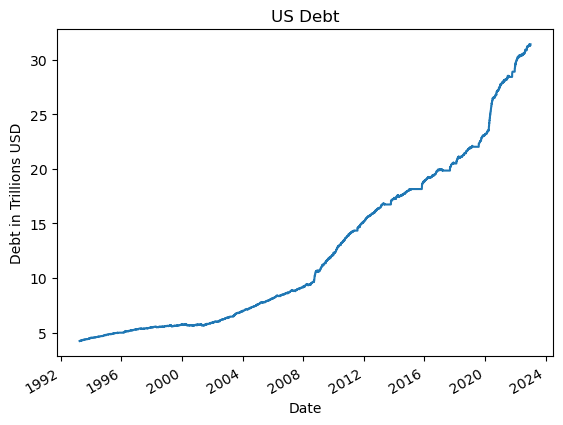

In [42]:
debt_to_penny_df['tot_pub_debt_out_amt'].plot()

plt.title('US Debt')
plt.xlabel('Date')
plt.ylabel('Debt in Trillions USD')
plt.show()

When we look at the graph of the US Debt per capita during the same period, we observe the same shape (but with a different scale). The trend is increasing as well (convex graph).

### US Debt aside Gold Price during some key periods

In [43]:
def plot_aside(start_date='1979', end_date='2023', crisis_periods=None):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot gold price data
    ax1.plot(gold_data_usd[start_date:end_date].index, gold_data_usd[start_date:end_date]['usd_price'], color='gold', label='Gold Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gold Price (USD)', color='gold')
    ax1.tick_params(axis='y', labelcolor='gold')

    # Create a second y-axis to plot US debt data
    ax2 = ax1.twinx()
    ax2.plot(debt_to_penny_df[start_date:end_date].index, debt_to_penny_df[start_date:end_date]['tot_pub_debt_out_amt'], color='blue', label='US Debt')
    ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and legend
    if crisis_periods:
        plt.title(f'Gold Price and US Debt during {crisis_periods}')
    else:
        plt.title('Gold Price and US Debt')
    #plt.title(f'Gold Price and US Debt during {crisis_periods}')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

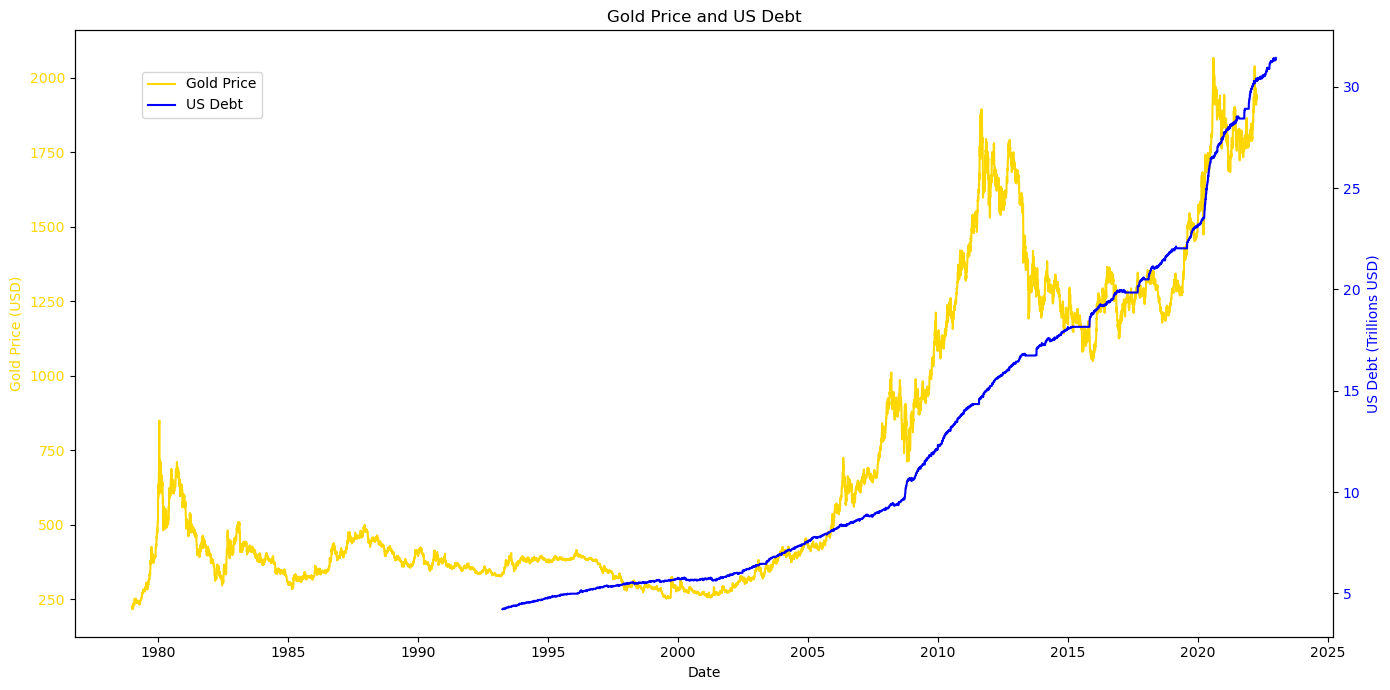

In [44]:
plot_aside()

### Heatmap of US Debt Variation and Gold variation

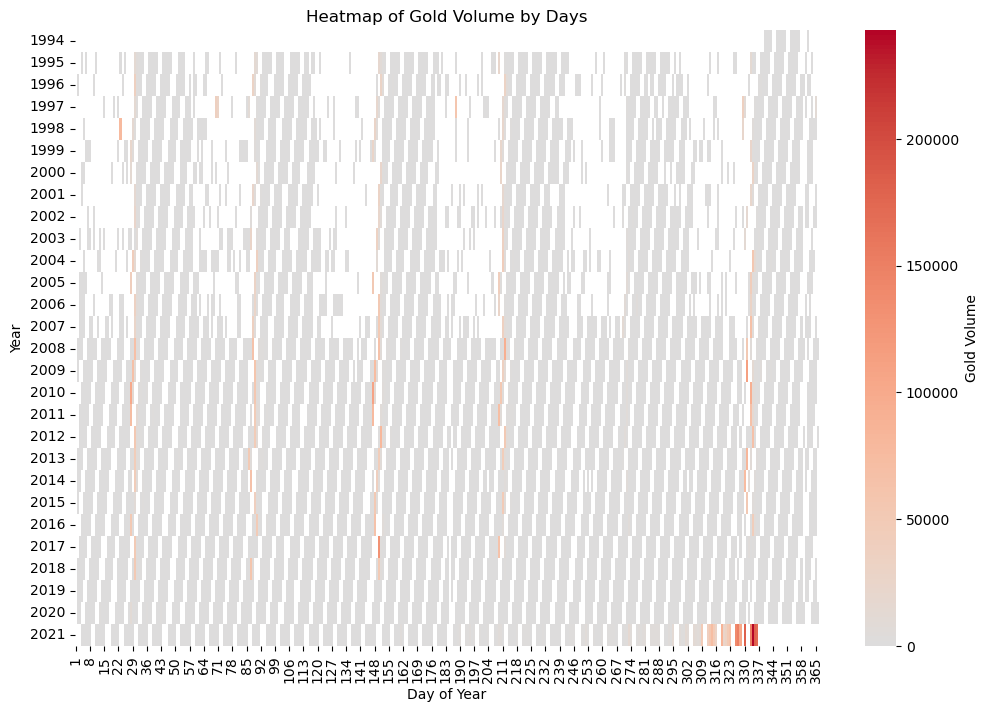

In [107]:
# Plot the heatmap for gold volume 
gold_daily_2 = gold_data_2.resample('D').ffill()
gold_daily_2['Year'] = gold_daily_2.index.year
gold_daily_2['DayOfYear'] = gold_daily_2.index.dayofyear
gold_daily_2['Gold_Volume'] = gold_data_2['Volume']

gold_volume_pivot = gold_daily_2.pivot('Year', 'DayOfYear', 'Gold_Volume')

plt.figure(figsize=(12, 8))
sns.heatmap(gold_volume_pivot, center=0, cmap='coolwarm', cbar_kws={'label': 'Gold Volume'})
plt.title('Heatmap of Gold Volume by Days')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()


We can notice some seasonality around the 29th, 85th, 148th, 211th and 330th days of the year. This could be correlated with macro economic annoucements at the end of some months. It could aslo be related to the last trading dates of futures if they are set to end of months. Furthemore, there is an important increase of the gold volume at the end of 2021.

### Heatmap of US Daily Return and Gold Daily Return

In [108]:
# Resample the data to daily frequency and fill missing values
debt_daily = debt_to_penny_df.resample('D').ffill()

# Create a pivot table with years as rows and days of the year as columns
debt_daily['Year'] = debt_daily.index.year
debt_daily['DayOfYear'] = debt_daily.index.dayofyear
# Calculate the daily variation in debt
debt_daily['Debt_Variation'] = debt_daily['tot_pub_debt_out_amt'].diff()

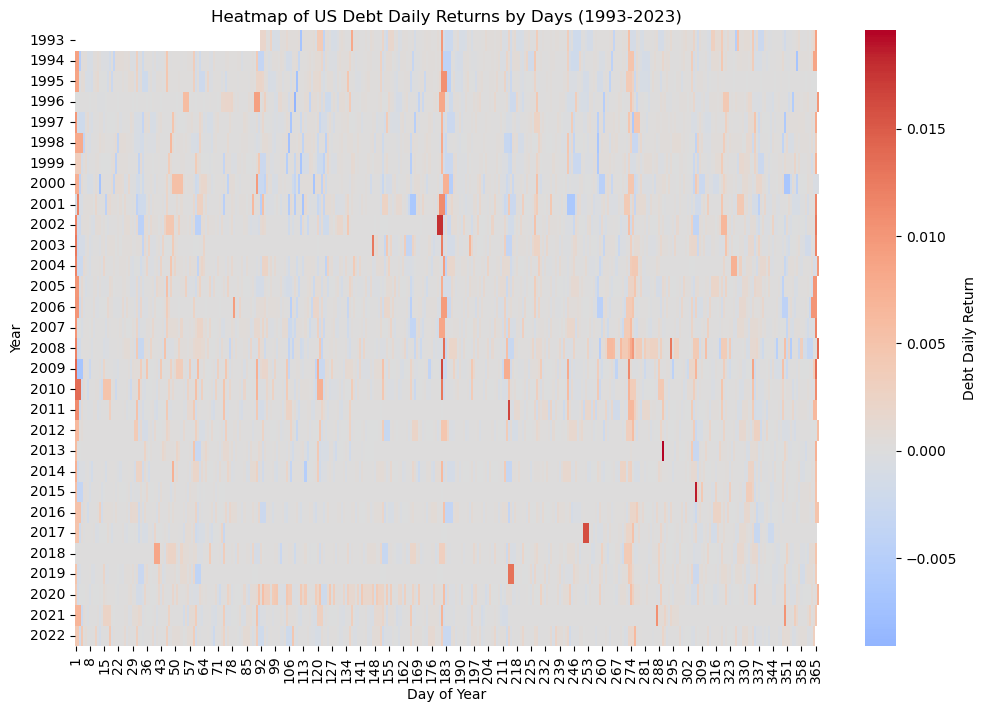

In [109]:
# Heatmap of Debt daily returns by year
debt_daily['Debt_Return'] = debt_daily['daily_return']
debt_return_pivot = debt_daily.pivot('Year', 'DayOfYear', 'Debt_Return')

plt.figure(figsize=(12, 8))
sns.heatmap(debt_return_pivot, cmap='coolwarm', center=0, cbar_kws={'label': 'Debt Daily Return'})
plt.title('Heatmap of US Debt Daily Returns by Days (1993-2023)')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

## Statistical Analysis

### Compute correlations between gold prices and US debt

In [ ]:
def correlation_analysis(periods):
    # Create a DataFrame to store the correlation values
    columns = pd.MultiIndex.from_product([["gold_vs_debt"],["correlation","correlation_daily_return"]])
    correlations = pd.DataFrame(data=[], index=periods.keys(), columns=columns)

    # Calculate and print the correlation for each period
    for period, (start_date, end_date) in periods.items():
        gold_period = gold_data_usd[start_date:end_date]
        debt_period = debt_to_penny_df[start_date:end_date]
        
        # Merge the dataframes on the date index
        merged_data = pd.merge(gold_period, debt_period, left_index=True, right_index=True)
        
        # Calculate the correlation
        correlation = merged_data['usd_price'].corr(merged_data['tot_pub_debt_out_amt'])
        correlations.loc[period,("gold_vs_debt","correlation")] = correlation
        
        # Calculate the correlation of daily returns
        correlation_dr = merged_data['daily_return_x'].corr(merged_data['daily_return_y'])
        correlations.loc[period,("gold_vs_debt","correlation_daily_return")] = correlation_dr
        
    return correlations

def find_best_correlated_periods(first_date, last_date):
    # create a dictionary to store the periods
    periods = {}

    # Look for the best correlation within first and last_date
    for i in range(1, 11):
        start_date = pd.to_datetime(first_date)
        end_date = start_date + pd.DateOffset(years=i)
        if end_date > pd.to_datetime(last_date):
            break
        periods[f'Period {i}'] = (start_date, end_date)

    # Calculate the correlation for each period
    correlations = correlation_analysis(periods)
    # Find the period with the highest correlation
    best_period = correlations.idxmax().values[0][0]

    return periods[best_period],correlations


In [ ]:
correlation_analysis(crisis_periods)

### Merging gold and debt data in one dataframe

In [110]:
full_data = gold_data_usd.merge(debt_to_penny_df, how="outer", left_index=True, right_index=True)
# rename columns and drop NaN values
full_data = full_data.rename(columns={"tot_pub_debt_out_amt": "debt_amt", "usd_price" : "gold_price", "daily_return_x": "gold_daily_return", "daily_return_y": "debt_daily_return", "daily_variation_x": "gold_daily_variation", "daily_variation_y": "debt_daily_variation"}).dropna()
full_data.head()

gold_price  gold_daily_return  gold_daily_variation  \
1993-04-02      340.10           0.011149                  3.75   
1993-04-05      339.25          -0.002499                 -0.85   
1993-04-06      338.40          -0.002506                 -0.85   
1993-04-07      336.75          -0.004876                 -1.65   
1993-04-08      337.50           0.002227                  0.75   

            volatility_7d  volatility_28d  volatility_90d  volatility_365d  \
1993-04-02       0.045521        0.016270        0.007961         0.005184   
1993-04-05       0.048514        0.016458        0.007982         0.005177   
1993-04-06       0.050365        0.016583        0.007998         0.005178   
1993-04-07       0.052345        0.016358        0.008044         0.005177   
1993-04-08       0.048870        0.016335        0.008053         0.005178   

            debt_amt  debt_daily_return  debt_daily_variation  
1993-04-02  4.233931           0.001907              0.008057  
1993-04-05  4.234896           0.000228              0.000965  
1993-04-06  4.235831           0.000221              0.000935  
1993-04-07  4.246168           0.002440              0.010337  
1993-04-08  4.242020          -0.000977             -0.004148

### Granger Causality Test

The Granger causality test is a statistical method used to determine whether a time series can predict another time series. Unlike a simple correlation analysis, which measures only the strength and direction of the linear relationship between two variables, the Granger test examines the ability of one variable to provide information about the future values of another variable.

#### Relevance to correlation analysis

1. **Directionality** : Correlation gives no information about the direction of the relationship. The Granger test can indicate whether X causes Y or whether Y causes X.
2. **Temporality**: Correlation is an instantaneous measure and does not take time lags into account. The Granger test incorporates time lags to assess the causal relationship.
3. **Prediction**: Correlation cannot be used for prediction, whereas the Granger Test is specifically designed to assess the predictive ability of one time series over another.


Statistique ADF: 0.46224540982484874
Valeur p: 0.9836792586204507
Valeurs critiques: {'1%': -3.4312530395833467, '5%': -2.861939073060013, '10%': -2.566982422386691}
Statistique ADF: 4.828381781456949
Valeur p: 1.0
Valeurs critiques: {'1%': -3.431252416490739, '5%': -2.8619387977434867, '10%': -2.566982275831387}


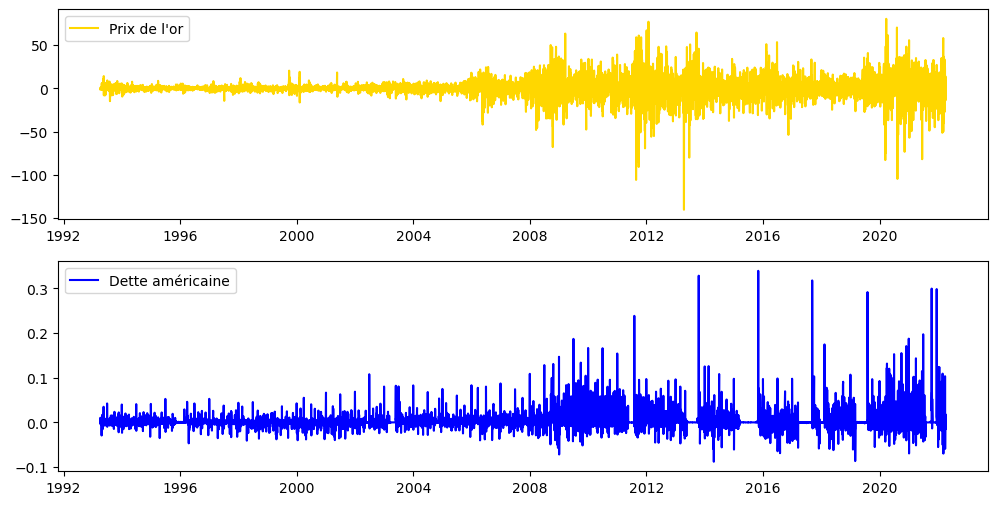

Statistique ADF: -15.846570752127864
Valeur p: 9.556242512213546e-29
Valeurs critiques: {'1%': -3.4312530395833467, '5%': -2.861939073060013, '10%': -2.566982422386691}
Statistique ADF: -9.471993868130813
Valeur p: 4.0827973233889256e-16
Valeurs critiques: {'1%': -3.4312525410404624, '5%': -2.8619388527763974, '10%': -2.5669823051262677}


/Users/paul-antoine/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -2.981      -2.979     0.05072      -2.981
1       -2.985      -2.980     0.05052      -2.983
2       -2.986      -2.977     0.05047      -2.983
3       -2.987      -2.974     0.05042      -2.983
4       -2.989      -2.971     0.05036      -2.983
5       -3.006      -2.985     0.04948      -2.999
6       -3.007      -2.983     0.04942      -2.999
7       -3.007      -2.979     0.04942      -2.998
8       -3.009      -2.976     0.04936      -2.997
9       -3.012      -2.976     0.04917      -3.000
10      -3.028      -2.988     0.04842      -3.014
11      -3.044     -3.000*     0.04765      -3.029
12      -3.046      -2.998     0.04757     -3.029*
13      -3.045      -2.993     0.04761      -3.027
14      -3.044      -2.989     0.04763      -3.025
15      -3.044      -2.985     0.04763      -3.024
16      -3.045      -2.982     

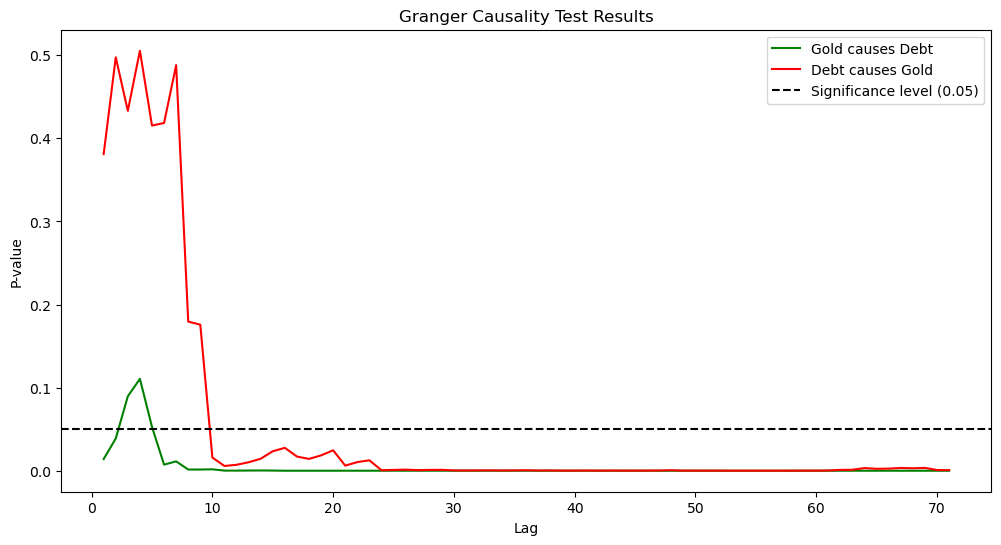

The optimal maxlag for daily data is 71 days so approximately 2 months


In [111]:
# Load data
data = full_data[['gold_price', 'debt_amt']]

# Check stationarity of the time series data
def check_stationarity(series):
    result = adfuller(series)
    print(f'Statistique ADF: {result[0]}')
    print(f'Valeur p: {result[1]}')
    print(f'Valeurs critiques: {result[4]}')
    return result[1] < 0.05  # Return True if the p-value is less than 0.05

# Apply ADF test to check stationarity
is_gold_price_stationary = check_stationarity(data['gold_price'])
is_us_debt_stationary = check_stationarity(data['debt_amt'])

# Differecing time series if necessary
if not is_gold_price_stationary:
    data['gold_price'] = data['gold_price'].diff().dropna()
if not is_us_debt_stationary:
    data['debt_amt'] = data['debt_amt'].diff().dropna()

# Drop missing values after differencing
data = data.dropna()

# Visualize the time series data after cleaning
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data['gold_price'], label='Prix de l\'or', color='gold')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data['debt_amt'], label='Dette américaine', color='blue')
plt.legend()
plt.show()

check_stationarity(data['gold_price'])
check_stationarity(data['debt_amt'])

# Make Granger Causality Test
max_lag = 90  # We will test up to 90 days of lag
model = VAR(data[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
print(lag_order.summary())

# Use the AIC criterion to determine the optimal lag order
optimal_lag = lag_order.aic

result_gold_cause_debt = grangercausalitytests(data[['gold_price', 'debt_amt']], optimal_lag, verbose=False) # Test de causalité de l'or sur la dette
result_debt_cause_gold = grangercausalitytests(data[['debt_amt', 'gold_price']], optimal_lag, verbose=False) # Test de causalité de la dette sur l'or

# Get p-values from the Granger Causality Test results
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualize p-values of Granger Causality Test
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results')
plt.legend()
plt.show()

print(f'The optimal maxlag for daily data is {optimal_lag} days so approximately {optimal_lag//30} months')

#### The problem of p-values tending towards 0

When the p-values drop to 0 for high lags in a Granger causality test, this can be due to several factors:

1. **Overfitting**: With a high number of lags, the model can start to overfit the data, capturing not only the true relationships but also random noise. This can lead to artificially low p-values, indicating apparent causality that is not actually present.

2. **Autocorrelation**: Time series can have strong autocorrelation, meaning that past values strongly influence future values. When the number of lags is high, the model can capture this autocorrelation, which can lead to low p-values.

3. **Spurious dependence**: With a large number of lags, it is possible for spurious relationships to be detected. This can occur when the model finds correlations that are not really causal but appear significant due to the large number of estimated parameters.

4. **Stationarity Problems**: If time series are not correctly stationary, this can lead to misleading results. Non-stationary series may show trends or cycles that can be misinterpreted as causal relationships.

5. **Sample size**: With a large number of lags, the number of parameters to be estimated increases, which can reduce the statistical power of the test, especially if the sample size is limited. This can also lead to artificially low p-values.

### Proposal: Data Aggregation

To alleviate these problems, one solution is to aggregate the data at a lower frequency, such as weekly or monthly. Aggregating data can help to:

- **Reduce Noise**: By smoothing out daily fluctuations, aggregation can reduce noise and make underlying trends more visible.
- **Simplify the Model**: With aggregated data, the number of lags required to capture temporal relationships can be reduced, thus decreasing the risk of over-fitting.
- **Improve Stationarity**: Aggregated data can be more stationary, making it easier to interpret the results of the Granger test.


Statistique ADF: 0.3437598765411659
Valeur p: 0.9792654547260407
Valeurs critiques: {'1%': -3.4347375276423335, '5%': -2.8634778123668374, '10%': -2.5678016687520104}
Statistique ADF: 4.477830298041579
Valeur p: 1.0
Valeurs critiques: {'1%': -3.434743423170358, '5%': -2.8634804142964025, '10%': -2.567803054306163}


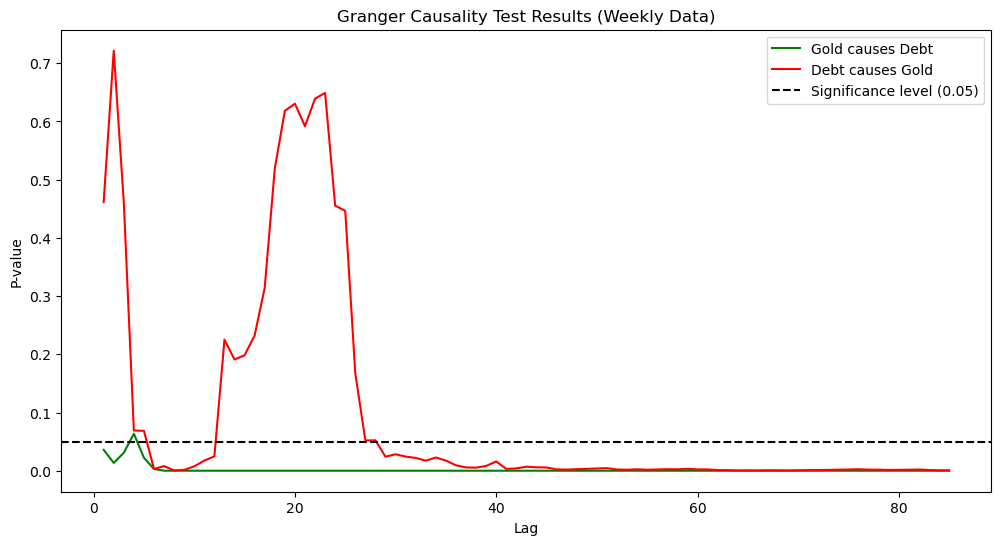

le maxlag optimal est pour les données hebdomadaires est 85 soit environ 21 mois
la p-value minimale pour la causalité de l'or sur la dette est 1.3185640315416392e-12 obtenue pour un lag de 80 semaines


In [ ]:
# Weekly aggregation
data_weekly = full_data[['gold_price', 'debt_amt']].resample('W').mean()

# Check stationarity of the time series and differentiate them if necessary
if not check_stationarity(data_weekly['gold_price']):
    data_weekly['gold_price'] = data_weekly['gold_price'].diff().dropna()
if not check_stationarity(data_weekly['debt_amt']):
    data_weekly['debt_amt'] = data_weekly['debt_amt'].diff().dropna()

# Drop missing values after differencing
data_weekly = data_weekly.dropna()

# Use the information criteria to find the optimal number of lags
model = VAR(data_weekly[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
optimal_lag = lag_order.aic

# Make the Granger causality test with the optimal number of lags
result_gold_cause_debt = grangercausalitytests(data_weekly[['gold_price', 'debt_amt']], optimal_lag, verbose=False)
result_debt_cause_gold = grangercausalitytests(data_weekly[['debt_amt', 'gold_price']], optimal_lag, verbose=False)

# Gt the p-values of the 2 Granger causality tests
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualize p-values
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results (Weekly Data)')
plt.legend()
plt.show()

print(f'The optimal maxlag for weekly data is {optimal_lag} so approximately {optimal_lag//4} weeks')
print(f'The minimal p-value minimale for gold causality on debt is {min(p_values_gold_cause_debt)} obtained for a {p_values_gold_cause_debt.index(min(p_values_gold_cause_debt))} weeks lag')

Statistique ADF: 0.2645274515074037
Valeur p: 0.9756571962484314
Valeurs critiques: {'1%': -3.449336554273722, '5%': -2.8699055166063085, '10%': -2.571226758215748}
Statistique ADF: 4.829950264455996
Valeur p: 1.0
Valeurs critiques: {'1%': -3.4493918438232525, '5%': -2.8699298018856574, '10%': -2.5712397066390458}


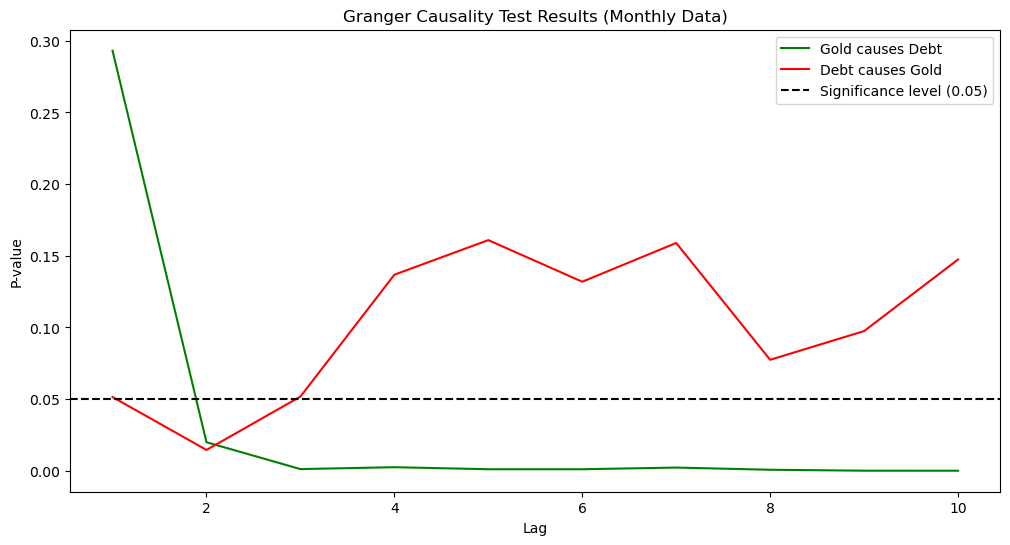

Le maxlag optimal pour les données mensuelles est 10 mois


In [ ]:
# Monthly agregation

data_monthly = full_data[['gold_price', 'debt_amt']].resample('M').mean()

# Differentiate time series if they are not stationary
if not check_stationarity(data_monthly['gold_price']):
    data_monthly['gold_price'] = data_monthly['gold_price'].diff().dropna()
if not check_stationarity(data_monthly['debt_amt']):
    data_monthly['debt_amt'] = data_monthly['debt_amt'].diff().dropna()

# Drop missing values after differentiation
data_monthly = data_monthly.dropna()

# Use information criteria to determine the optimal number of lags

max_lag = 36  # We try lags until 36 months (3 years)
model = VAR(data_monthly[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
optimal_lag = lag_order.aic

# Make the Granger Causality test with the optimal number of lags
result_gold_cause_debt = grangercausalitytests(data_monthly[['gold_price', 'debt_amt']], optimal_lag, verbose=False)
result_debt_cause_gold = grangercausalitytests(data_monthly[['debt_amt', 'gold_price']], optimal_lag, verbose=False)

# Get the p-values of the 2 Granger causality tests
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualize the p-values
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results (Monthly Data)')
plt.legend()
plt.show()

print(f'The optimal maxlag for monthly data is {optimal_lag} months')

Whatever the time scale, the G->D hypothesis seems more plausible than D->G (see p-value interpretation).

Disclaimer: this statistical analysis should be taken as advisory only. 

## ML Model for Signal Detection

Design an ML model that uses gold market data to obtain signals about possible unanticipated moves in US debt as a basis for designing a trading strategy that takes advantage of our predictions of the US debt profile.

---
#### Steps:

- Design a classification model and/or a regression model.
- Design a trading strategy based on these models and gold market data.
- Bonus: Design a trading strategy based on Fed and debt profile data and compare performance with the previous strategy. 


### Model Implementation

- **Features** : `gold_price`, `gold_volume`, `gold_vol7d`, `gold_vol28d`, `gold_vol90d`, `gold_variation`, `gold_return`.
- **Target**: Classify the debt delta profile over a time horizon of `x` days/weeks/months (`repayment`, `debt`, `overdebt`). Ideally run a regression to predict the debt delta by the time horizon tested.
- **Rational**: The aim is to find out whether particular patterns (e.g. large volume traded, sudden change in volatility, or other) predict sudden accelerations or early repayments of US debt and whether gold really serves as a leading indicator or whether Fed rates/announcements and past values of the debt profile are sufficient to anticipate these movements.
- **Hyperparemeter** : 
    - `x` (the time horizon over which the signal best predicts over-indebtedness)
    - `q` quantile which defines the threshold s on the basis of relative variations in debt over `x’ days.
    - `s` = `f(q,x)` (the classification threshold used to distinguish debt from over-indebtedness) 


#### Data Preprocessing and Feature Engineering

In [120]:
class CustomFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self):
      return self

    def transform(self, X):
        X = X.copy()
        X['gold_vol7d'] = X['gold_return'].rolling(window=7).std() * ((365/7)**0.5)
        X['gold_vol28d'] = X['gold_return'].rolling(window=28).std() * ((365/28)**0.5)
        X['gold_vol90d'] = X['gold_return'].rolling(window=90).std() * ((365/90)**0.5)
        X['gold_volume_variation'] = X['gold_volume'].diff().fillna(0)
        X['gold_variation'] = X['gold_price'].diff()
        X['gold_volume_absolut_variation'] = abs(X['gold_volume_variation'])
        X['gold_volume_absolut_variation_7d'] = X['gold_volume_absolut_variation'].rolling(window=7).sum()
        X['gold_volume_absolut_variation_28d'] = X['gold_volume_absolut_variation'].rolling(window=28).sum()
        X['gold_volume_absolut_variation_90d'] = X['gold_volume_absolut_variation'].rolling(window=90).sum()
        X.dropna(inplace=True)
         
        return X

# Target Engineering
class DebtDeltaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, x, q):
        self.x = x
        self.q = q

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Computation of the debt's relative variation over x days
        X['debt_delta'] = (X['debt_amt'].shift(-self.x) - X['debt_amt']) / X['debt_amt']
        # Computation of s which is the top q quantile of the debt_delta distribution playing the role of threshold for the classification of the target variable (repayment, indebtment, over-indebtment)
        s = X['debt_delta'].quantile(self.q)
        X['target'] = pd.cut(X['debt_delta'], bins=[-np.inf, 0, s, np.inf], labels=['remboursement', 'endettement', 'surendettement'])
        X.dropna(subset=['target'], inplace=True)
        return X

# Data loading
gold_data = gold_data_2[['Price', 'Volume', 'Daily_return']].rename(columns={'Price': 'gold_price', 'Volume': 'gold_volume', 'Daily_return': 'gold_return'})
debt_data = debt_to_penny_df[['tot_pub_debt_out_amt']].rename(columns={'tot_pub_debt_out_amt': 'debt_amt'})

# Data preprocessing
data = pd.merge(gold_data, debt_data, left_index=True, right_index=True)
data.dropna(inplace=True)
data = CustomFeatureEngineering().transform(data)



#### Plot of the target characteristics for x,q

In [97]:

def plot_target_characteristics(data, x=30, q=0.95, periods=decenal_periods):
    data = DebtDeltaTransformer(x, q).transform(data)
    
    s = data['debt_delta'].quantile(q)

    # histogram of debt_delta
    data['debt_delta'].hist(bins=50)
    plt.title(f"Distribution of debt's variation ({x} days horizon)")
    plt.xlabel("Debt's variation")
    plt.ylabel('Frequency')
    plt.show()

    # count the number of days where the debt_delta is above the threshold
    print(f"We count {data[data['debt_delta'] > s].shape[0]} days over a total of {data.shape[0]} where the debt's relative variation over the next {x} days is greater than the threshold {round(s,2)}")

    # Target classification in 3 classes : repayment, indebtment et over-indebtment
    data['target'] = pd.cut(data['debt_delta'], bins=[-np.inf, 0, s, np.inf], labels=['remboursement', 'endettement', 'surendettement'])

    # Drop rows with missing target
    data.dropna(subset=['target'], inplace=True)
    # Plots gold_data and debt_data aside put vertical red line when target is over-indebtment

    def plot_aside_3(start_date='1979', end_date='2023', crisis_periods=None):
        fig, ax1 = plt.subplots(figsize=(14, 7))

        # Plot gold price data
        ax1.plot(gold_data[start_date:end_date].index, gold_data[start_date:end_date]['gold_price'], color='gold', label='Gold Price')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Gold Price (USD)', color='gold')
        ax1.tick_params(axis='y', labelcolor='gold')

        # Create a second y-axis to plot US debt data
        ax2 = ax1.twinx()
        ax2.plot(debt_data[start_date:end_date].index, debt_data[start_date:end_date]['debt_amt'], color='blue', label='US Debt')
        ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        # Add title and legend
        plt.title(f'Gold Price and US Debt during {crisis_periods}')
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

        # Add vertical lines for surendettement if the surrounding data is in the period
        surendettement_dates = data[data['target'] == 'surendettement'].index
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        for date in surendettement_dates:
            if start_date < date < end_date:
                ax1.axvline(date, color='red', linestyle='--')
        plt.show()
    
    for period_name, (start_date, end_date) in periods.items():
        plot_aside_3(start_date=start_date, end_date=end_date, crisis_periods=period_name)


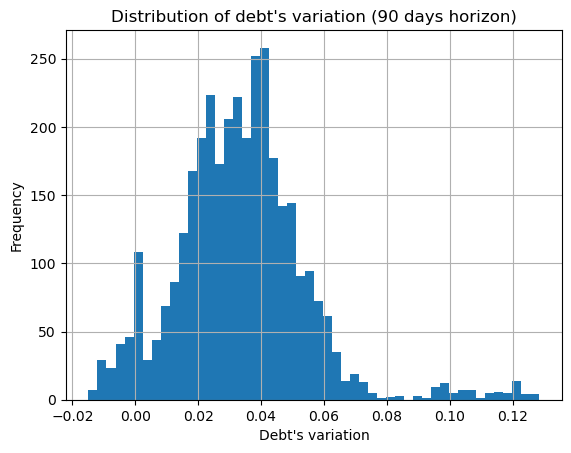

We count 173 days over a total of 3446 where the debt's relative variation over the next 90 days is greater than the threshold 0.06


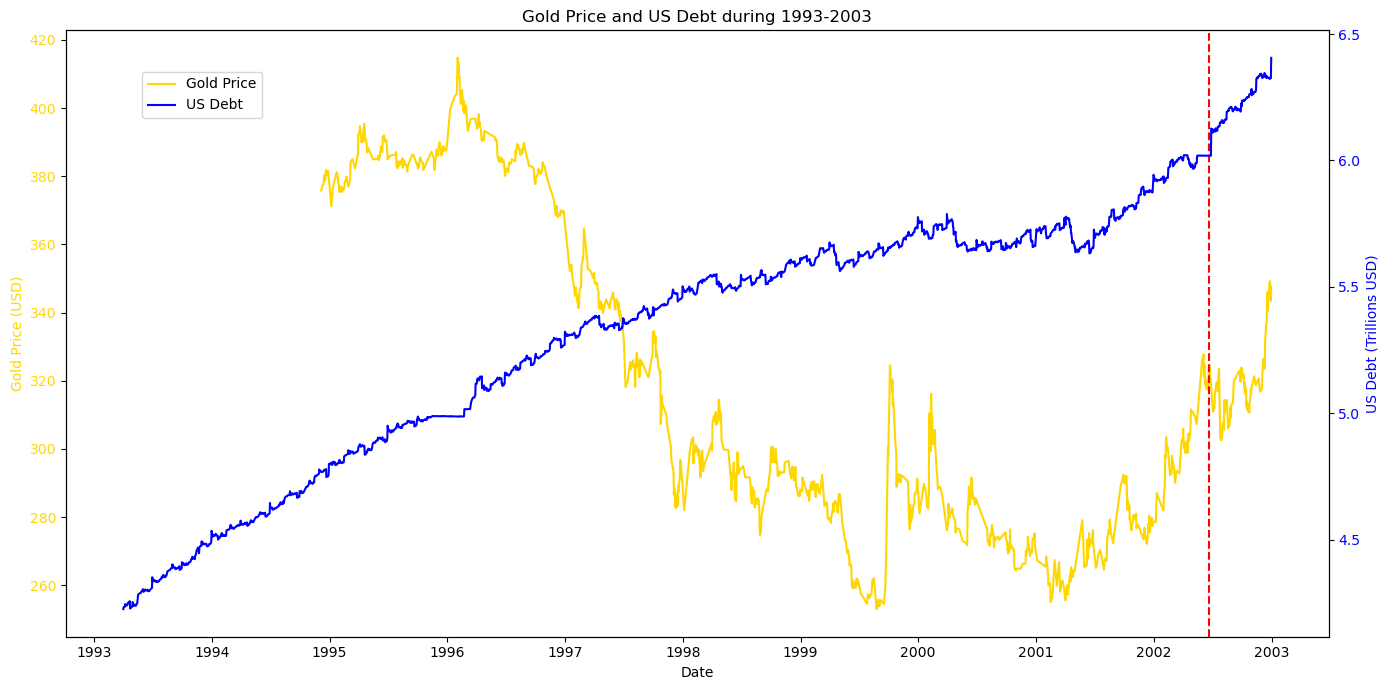

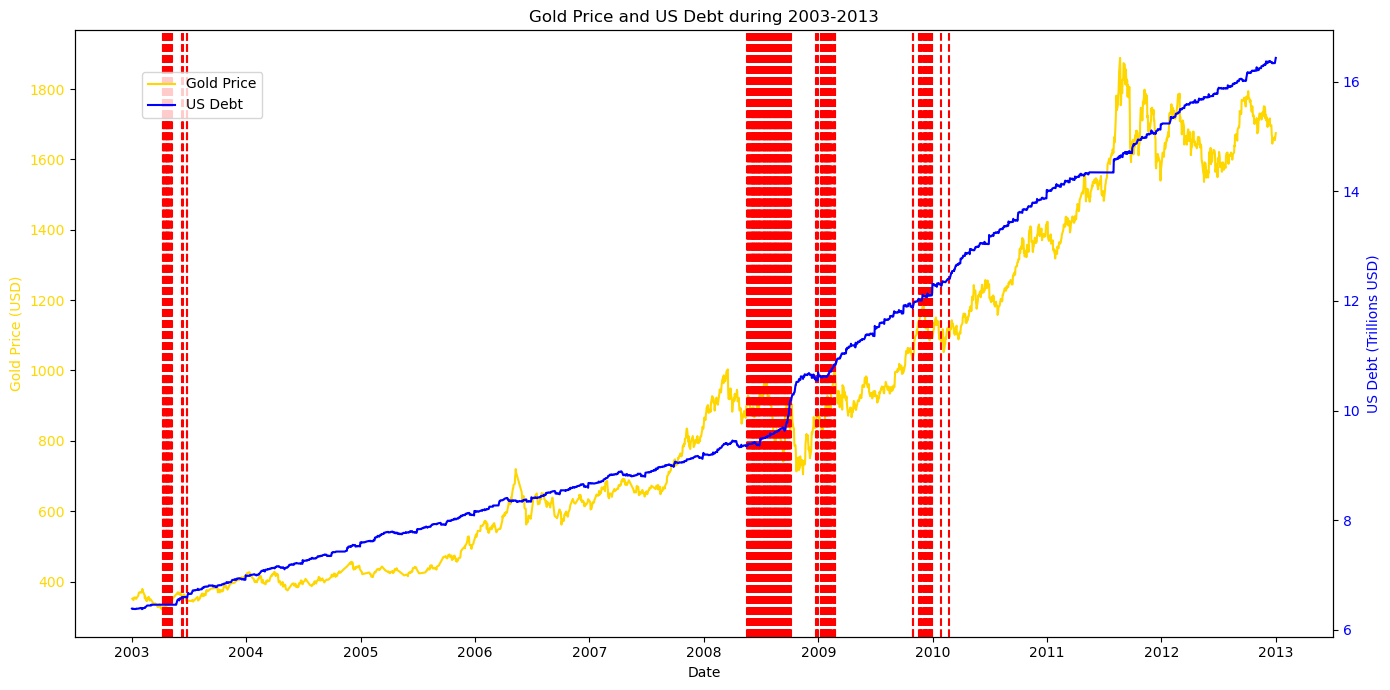

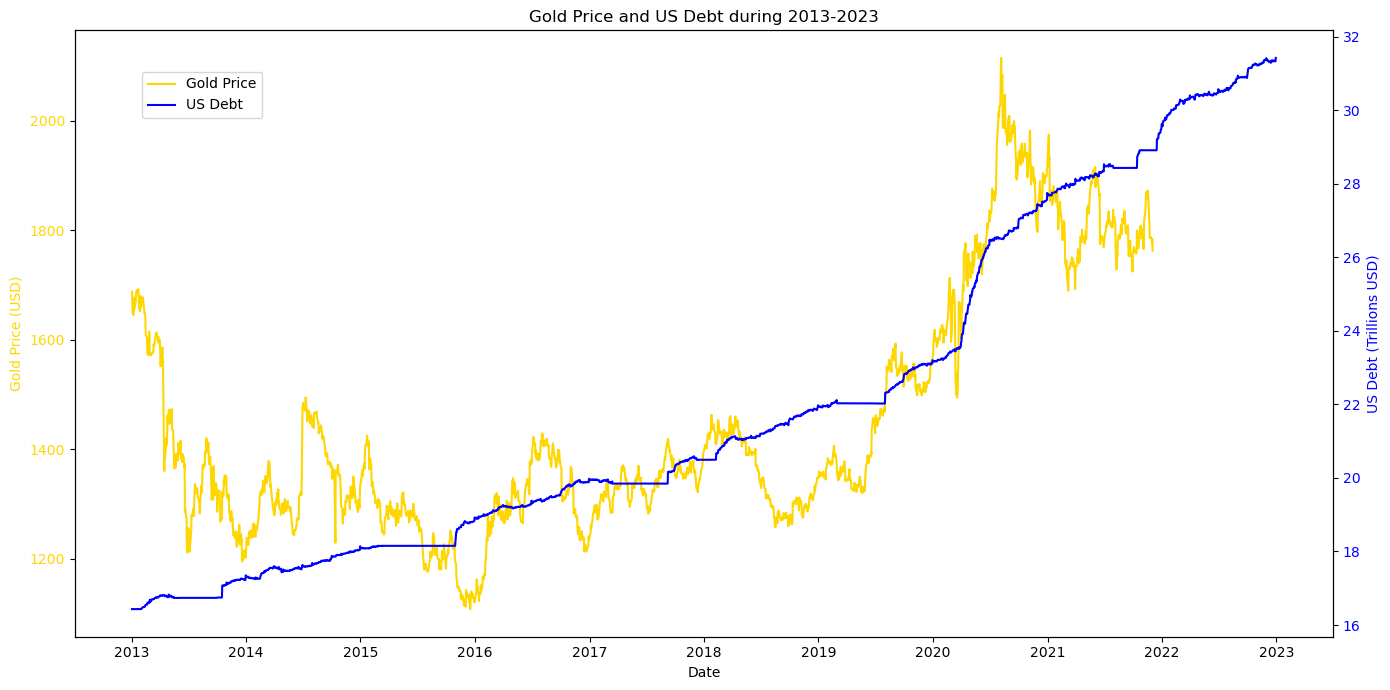

In [98]:
plot_target_characteristics(data, x=90, q=0.95, periods=decenal_periods)

#### Vanilla Model
- We try to predict the `target` classification of incoming `debt_delta` only with `gold` data
- Vanilla = without optimization over x,q, threshold classification and without feature selection

In [87]:
# Model Pipeline for Target Classification

def Vanilla_Classifier(x,q, data, feature_selection=False, verbose=False):
    # Target creation
    data = DebtDeltaTransformer(x, q).transform(data)

    # Train test split on data
    X, y = data.drop(columns=['debt_delta', 'target']), data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    CLASSIFIER_OPTIONS = {
        "n_estimators": [100,300],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5, 7],
    }

    grid = GridSearchCV(GradientBoostingClassifier(), cv=TimeSeriesSplit(n_splits=5), param_grid=CLASSIFIER_OPTIONS, n_jobs=-1, verbose=verbose)
    grid.fit(X_train, y_train)
    return grid, X_test, y_test

#### Model Evaluation for a given (x,q)

In [ ]:
def evaluate_vanilla_model(x, q, data,verbose=False):
    
    model, X_test, y_test = Vanilla_Classifier(x, q, data, verbose=verbose)
    
    # Prédiction des classes de la target
    y_pred = model.predict(X_test)

    if verbose:
        # Affichage des meilleurs paramètres et meilleure méthode de réduction de dimension
        print(f"Meilleurs paramètres: {model.best_params_}")

        # Affichage du rapport de classification
        print(classification_report(y_test, y_pred))
        
        # Matrice de confusion
        confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        plt.figure(figsize=(10, 6))
        heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Matrice de confusion')
        plt.show()

    return accuracy_score(y_test, y_pred), model


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
                precision    recall  f1-score   support

   endettement       0.81      1.00      0.90       605
 remboursement       0.00      0.00      0.00        97
surendettement       0.00      0.00      0.00        42

      accuracy                           0.81       744
     macro avg       0.27      0.33      0.30       744
  weighted avg       0.66      0.81      0.73       744



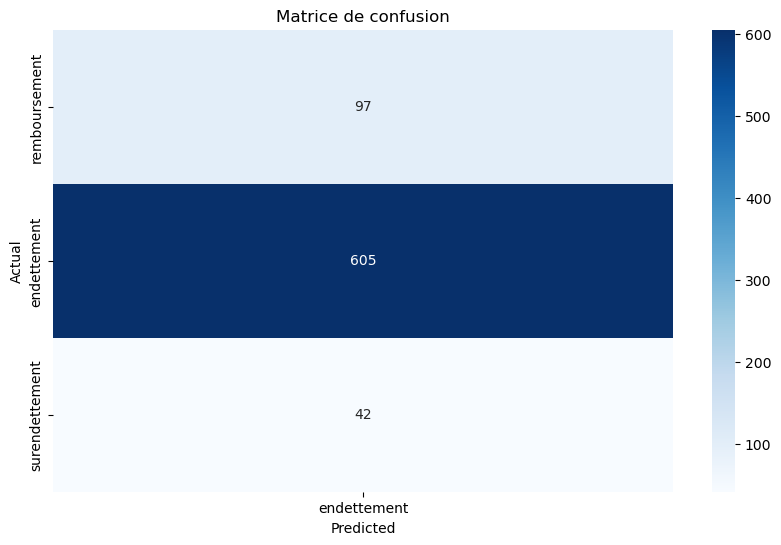

(0.8131720430107527,
 GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=GradientBoostingClassifier(), n_jobs=-1,
              param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                          'n_estimators': [100, 300]},
              verbose=True))

In [91]:
evaluate_vanilla_model(30, 0.80, data, verbose=True)

We notice that the model is completely biased towards indebtment because it is the most represented class. We thus need to correct this bias : using sampling or a different loss function.

### Model Optimization

- **Optimisation of hyper-parameters and their impact on feature selection**: Once we know how to train and then test the performance of a model, we need to look for the optimal `x` and `q` parameters (Cross-Validation) and observe whether/how the feature selection performed by the PCA/NMF or SelectKBest changes as a function of ``x`` and ``q``.
- **Redefinition of the target**: the classification target was defined by the relative variation of the debt over the `x` day horizon, but we could imagine defining it in relation to exceeding a threshold volatility level `s` or cumulative variation to take into account all the paths between ``t`` and ``t+x``.  
- **Optimising the ``classification_threshold``**: depending on whether you prefer high precision or high recall, given that the cost of making the mistake of classifying over-indebtedness as repayment was worse than any other missclassification because variations relating to over-indebtedness were more violent than variations relating to repayment (https://scikit-learn.org/stable/modules/classification_threshold.html).

- **Bonus**: 
    - **Data transformation and feature augmentation**: add features linked to `debt_amt`. We can also try to transform our data (``gold price`` ``inflation-ajusted``, ``debt_amt`` deflated by ``GDP`` or GDP/capita).
    - **Incorporate macroeconomic data**: Add macroeconomic indicators available through the API such as unemployment rates, inflation (TIPS and CPI), and interest rates to improve predictions.
    - **Comparative model analysis**: From classification to (logistic) regression. Testing different types of boosted trees, and then seeing whether implementing RNNs such as LSTM to take account of time series dependency relationships can improve performance.
    - **Analysis of seasonality**: Study the seasonal effects on gold prices and US debt -> vary the scale of the data (until now we've been working with daily data, but as we saw in the Granger Causality section, it might be interesting to go back to weekly or monthly data). 

#### Threshold Tuning 

In [ ]:
# Definition of a cost matrix for classification (getting the debt/over-indebtedness pair wrong is less serious than repayment)

COST_MATRIX = np.array([
    [0, 10, 10],  # True label 0
    [10, 0, 1],   # True label 1
    [10, 1, 0]    # True label 2
])

def cost_sensitive_metric(y_true, y_pred):
    """
    Custom cost-sensitive metric based on a cost matrix
    """
    cost = 0
    mapping = {"remboursement": 0, "endettement": 1, "surendettement": 2}
    for true, pred in zip(y_true, y_pred):
        cost += COST_MATRIX[mapping.get(true), mapping.get(pred)]
    return -cost / len(y_true)  # Negative because GridSearchCV maximizes the scorer

# Create a scorer
cost_scorer = make_scorer(cost_sensitive_metric, greater_is_better=True)

In [14]:
# Grid Search parameters to optimize the model
N_FEATURES_OPTIONS = [3,5,7,9]
CLASSIFIER_OPTIONS = {
    "classify__n_estimators": [100,300],
    "classify__learning_rate": [0.01, 0.1, 0.3],
    "classify__max_depth": [3, 5, 7, 9],
    "classify__subsample": [0.8, 0.9],
}

#### Create pipeline, fit and evaluate models with cross validation and Grid Search

In [ ]:
# Model Pipeline for Target Classification with Scaler, Features Selections and Classifier

def Tuned_Classifier(x,q, data, feature_selection=False, verbose=False, n_features_options=N_FEATURES_OPTIONS, classifier_options=CLASSIFIER_OPTIONS, scoring_method="accuracy"):
    # Target creation
    data = DebtDeltaTransformer(x, q).transform(data)

    # Train test split on data
    X, y = data.drop(columns=['debt_delta', 'target']), data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    param_grid = [
        {
            "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
            "reduce_dim__n_components": N_FEATURES_OPTIONS,
            "classify__n_estimators": CLASSIFIER_OPTIONS["classify__n_estimators"],
            "classify__learning_rate": CLASSIFIER_OPTIONS["classify__learning_rate"],
            "classify__max_depth": CLASSIFIER_OPTIONS["classify__max_depth"],
            "classify__subsample": CLASSIFIER_OPTIONS["classify__subsample"],
        },
        {
            "reduce_dim": [SelectKBest(mutual_info_classif)],
            "reduce_dim__k": N_FEATURES_OPTIONS,
            "classify__n_estimators": CLASSIFIER_OPTIONS["classify__n_estimators"],
            "classify__learning_rate": CLASSIFIER_OPTIONS["classify__learning_rate"],
            "classify__max_depth": CLASSIFIER_OPTIONS["classify__max_depth"],
            "classify__subsample": CLASSIFIER_OPTIONS["classify__subsample"],
        },
    ]

  
    if feature_selection:
        # TimeSeriesSplit and GridSearchCV
        pipe = Pipeline(
        [
            ("scaling", StandardScaler()),
            # the reduce_dim stage is populated by the param_grid
            ("reduce_dim", "passthrough"),
            ("classify", GradientBoostingClassifier()),
        ]
    )
        grid = GridSearchCV(
            pipe, 
            cv=TimeSeriesSplit(n_splits=5), 
            param_grid=param_grid, 
            scoring = scoring_method, 
            verbose=verbose, 
            random_state=42, 
            n_jobs=-1) # TunedThresholdClassifierCV in version 1.5 of sklearn would be better

    else:
        pipe = Pipeline(
        [
            ("scaling", StandardScaler()),
            ("classify", GradientBoostingClassifier()),
        ]
    )
        grid = GridSearchCV(
            pipe, 
            cv=TimeSeriesSplit(n_splits=5), 
            param_grid=CLASSIFIER_OPTIONS, 
            scoring = scoring_method, 
            verbose=verbose, 
            random_state=42, 
            n_jobs=-1) # TunedThresholdClassifierCV in version 1.5 of sklearn would be better

    grid.fit(X_train, y_train)
    return grid, X_test, y_test

In [ ]:
# Model Pipeline for Target Classification with Scaler, Imbalanced sampling Features Selections and Classifier

def Tuned_Classifier_imbalanced(x,q, data, feature_selection=False, verbose=False, n_features_options=N_FEATURES_OPTIONS, classifier_options=CLASSIFIER_OPTIONS, scoring_method="accuracy"):
    # Target creation
    data = DebtDeltaTransformer(x, q).transform(data)

    # Train test split on data
    X, y = data.drop(columns=['debt_delta', 'target']), data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    param_grid = [
        {
            "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
            "reduce_dim__n_components": N_FEATURES_OPTIONS,
            "classify__n_estimators": CLASSIFIER_OPTIONS["classify__n_estimators"],
            "classify__learning_rate": CLASSIFIER_OPTIONS["classify__learning_rate"],
            "classify__max_depth": CLASSIFIER_OPTIONS["classify__max_depth"],
            "classify__subsample": CLASSIFIER_OPTIONS["classify__subsample"],
        },
        {
            "reduce_dim": [SelectKBest(mutual_info_classif)],
            "reduce_dim__k": N_FEATURES_OPTIONS,
            "classify__n_estimators": CLASSIFIER_OPTIONS["classify__n_estimators"],
            "classify__learning_rate": CLASSIFIER_OPTIONS["classify__learning_rate"],
            "classify__max_depth": CLASSIFIER_OPTIONS["classify__max_depth"],
            "classify__subsample": CLASSIFIER_OPTIONS["classify__subsample"],
        },
    ]

  
    if feature_selection:
        # TimeSeriesSplit and GridSearchCV
        pipe = ImbPipeline(
        [
            ("resampling", SMOTE()),
            ("scaling", StandardScaler()),
            # the reduce_dim stage is populated by the param_grid
            ("reduce_dim", "passthrough"),
            ("classify", GradientBoostingClassifier()),
        ]
    )
        grid = GridSearchCV(
            pipe, 
            cv=TimeSeriesSplit(n_splits=5), 
            param_grid=param_grid, 
            scoring=scoring_method, 
            verbose=verbose, 
            random_state=42, 
            n_jobs=-1) # TunedThresholdClassifierCV in version 1.5 of sklearn would be better

    else:
        pipe = ImbPipeline(
        [
            ("resampling", SMOTE()),
            ("scaling", StandardScaler()),
            ("classify", GradientBoostingClassifier()),
        ]
    )
        grid = GridSearchCV(
            pipe,
            cv=TimeSeriesSplit(n_splits=5),
            param_grid=CLASSIFIER_OPTIONS,
            scoring=scoring_method, 
            verbose=verbose,
            random_state=42, 
            n_jobs=-1) # TunedThresholdClassifierCV in version 1.5 of sklearn would be better

    grid.fit(X_train, y_train)
    return grid, X_test, y_test



In [ ]:
def evaluate_tuned_model(x, q, data, verbose=False, feature_select = False, imbalance=False, scoring_method="accuracy"):
    
    if not imbalance:
        model, X_test, y_test = Tuned_Classifier(x=x, q=q, data=data, scoring_method=scoring_method)
    else:
        model, X_test, y_test = Tuned_Classifier_imbalanced(x=x, q=q, data=data, scoring_method=scoring_method)
    
    # Target prediction
    y_pred = model.predict(X_test)

    if verbose:
        # Display the best parameters and the best dimensionality reduction method
        print(f"Best parameters: {model.best_params_}")
        if feature_select:
            print(f"Best dimensionality reduction method: {model.best_estimator_.named_steps['reduce_dim']}")

        # Display classification report
        print(classification_report(y_test, y_pred))
        
        # Confusion matrix
        confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        plt.figure(figsize=(10, 6))
        heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Matrice de confusion')
        plt.show()

    return accuracy_score(y_test,y_pred), model

#### Tuned Model

In [77]:
# Grid-Search like function to Fine Tune the model with x and q
param_grid = {
    'x': [7, 28],
    'q': [0.7,0.8,0.9,0.95],
}

def fine_tune_model(param_grid, verbose=False, feature_selection = False, imbalance=False, scoring_method="accuracy"):
    best_model = None
    best_score = -np.inf
    best_params = None
    best_features = None
    grid_search_results = pd.DataFrame()
    c = 1
    for x in param_grid['x']:
        for q in param_grid['q']:
            score,model = evaluate_tuned_model(x,q,data, verbose=verbose, imbalance=imbalance, scoring_method=scoring_method)
            gs_res = pd.DataFrame(model.cv_results_)
            gs_res['x'] = x
            gs_res['q'] = q
            gs_res["configuration"] = c
            c+=1
            grid_search_results = pd.concat([grid_search_results, gs_res])
            if verbose:
                print(f'Score for x={x} and q={q}: {score}')
            if score > best_score:
                best_model = model
                best_score = score
                best_params = {'x': x, 'q': q}
                if feature_selection:
                    best_features = model.best_estimator_.named_steps['reduce_dim'].get_support(indices=True)
    return best_model, best_params, best_score, best_features, grid_search_results

In [ ]:
def plot_confusion_matrix(model, best_params, data, title):
    data = DebtDeltaTransformer(best_params.get("x"), best_params.get("q")).transform(data)
    X, y = data.drop(columns=['debt_delta', 'target']), data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    y_pred = model.predict(X_test)
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(10, 6))
    heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion matrix {title}")
    plt.show()

#### Results Grid Search (no real need to run, comparison is done below)

Meilleurs paramètres trouvés: {'x': 28, 'q': 0.9}
Meilleure score: 0.7207415990730012


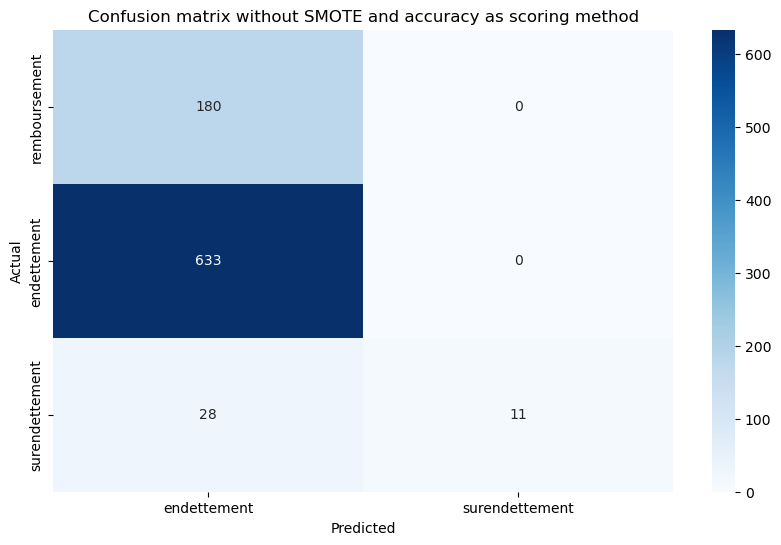

In [ ]:
# Fine tune the model without SMOTE and accuracy as scoring method 
# Warning : the cell takes approximately 30 min to run

best_model_acc, best_params_acc, best_score_acc, best_features_acc, grid_search_results_acc = fine_tune_model(param_grid, verbose=False, imbalance=False, scoring_method="accuracy")
print(f"Best parameters found: {best_params_acc}")
print(f"Best score: {best_score_acc}")
#print(f"Meilleures caractéristiques sélectionnées: {best_features}")
plot_confusion_matrix(best_model_acc, best_params_acc, data, "without SMOTE and accuracy as scoring method")

Meilleurs paramètres trouvés: {'x': 7, 'q': 0.95}
Meilleure score: 0.5023640661938534


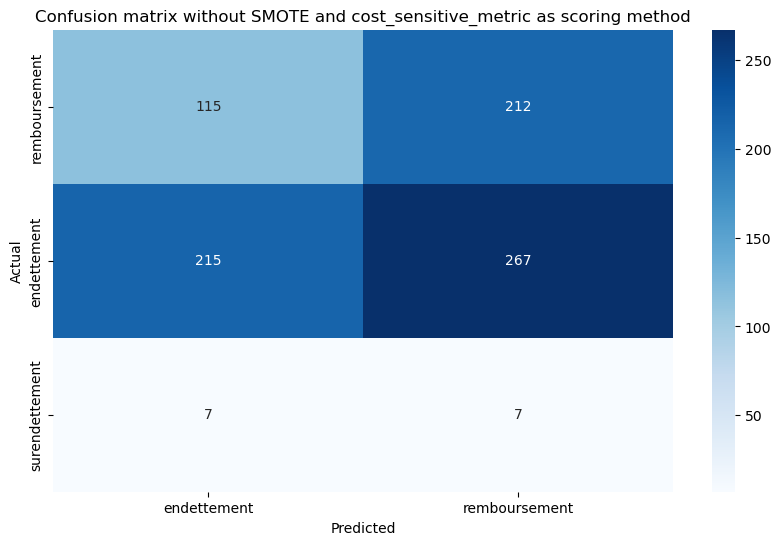

In [ ]:
# Fine tune the model without SMOTE and cost_sensitive_metric as scoring method
# Warning : the cell takes approximately 30 min to run

best_model_cost, best_params_cost, best_score_cost, best_features_cost, grid_search_results_cost = fine_tune_model(param_grid, verbose=False, imbalance=False, scoring_method=cost_scorer)
print(f"Best parameters found: {best_params_cost}")
print(f"Best score: {best_score_cost}")
#print(f"Meilleures caractéristiques sélectionnées: {best_features}")
plot_confusion_matrix(best_model_cost, best_params_cost, data, "without SMOTE and cost_sensitive_metric as scoring method")

Meilleurs paramètres trouvés: {'x': 28, 'q': 0.95}
Meilleure score: 0.7245283018867924


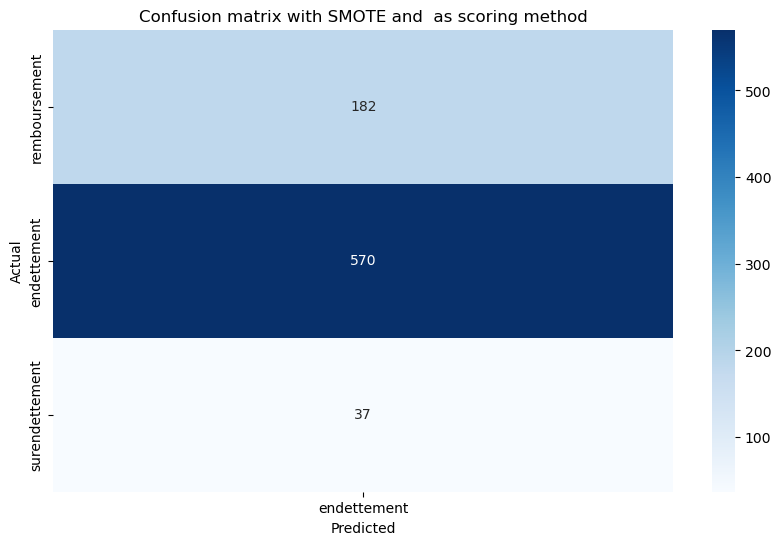

In [ ]:
# Fine tune the model with SMOTE and accuracy as scoring method
# Warning : the cell takes approximately 50 min to run

best_model_smote_acc, best_params_smote_acc, best_score_smote_acc, best_features_smote_acc, grid_search_results_smote_acc = fine_tune_model(param_grid, verbose=False, imbalance=True, scoring_method="accuracy")
print(f"Best parameters found: {best_params_smote_acc}")
print(f"Best score: {best_score_smote_acc}")
#print(f"Meilleures caractéristiques sélectionnées: {best_features_smote_acc}")
plot_confusion_matrix(best_model_smote_acc, best_params_smote_acc, data, "with SMOTE and accuracy as scoring method")

Best parameters found: {'x': 28, 'q': 0.95}
Best score: 0.8331143232588699


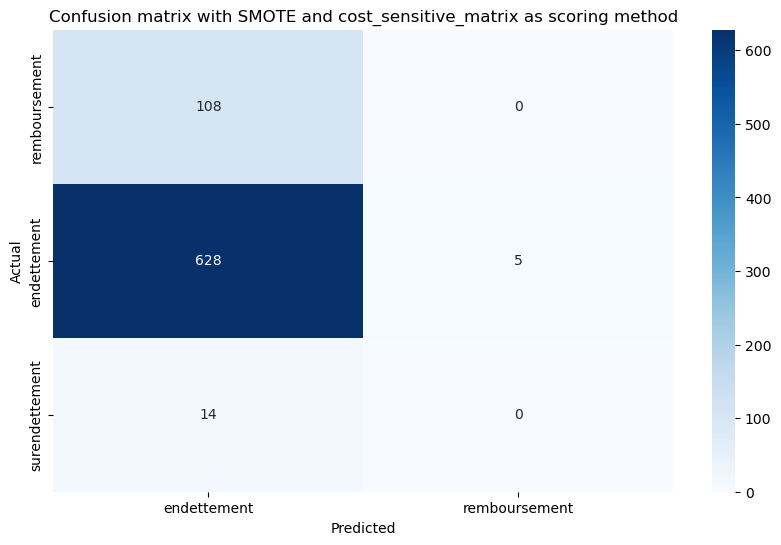

In [ ]:
# Fine tune the model with SMOTE and cost_sensitive_matrix as scoring method
# Warning : the cell takes approximately 50 min to run

best_model_smote_cost, best_params_smote_cost, best_score_smote_cost, best_features_smote_cost, grid_search_results_smote_cost = fine_tune_model(param_grid, verbose=False, imbalance=True, scoring_method=cost_scorer)
print(f"Best parameters found: {best_params_smote_cost}")
print(f"Best score: {best_score_smote_cost}")
#print(f"Meilleures caractéristiques sélectionnées: {best_features_smote_acc}")
plot_confusion_matrix(best_model_smote_cost, best_params_smote_cost, data, "with SMOTE and cost_sensitive_matrix as scoring method")

#### Comparing results

We tried to optimize the quantile to split between indebtment and over-indebtment. But mechanically, increasing the quantile will lead to less over-indebtment data, more indebtment and thus a higher score (either accuracy or cost sensitve) because the model will most likely always predict indebtment. So one must be careful when analyzing the results between the models because they have not been achieved on the same dataset.


It seems the best results are obtained where the time horizon is set to ``x = 28`` days. We will also fix ``q = 0.9`` in the following to have a non negligeable amount of over-indebtment data.

In [117]:
def comparison_all_models():
    score_method = ["accuracy", cost_scorer]
    with_smote = [False, True]
    for smote in with_smote:
        best_model, _, _, _, _ = fine_tune_model({"x":[28],"q":[0.9]}, verbose=False, imbalance=smote, scoring_method="accuracy")
        plot_confusion_matrix(best_model, {"x":28,"q":0.9}, data, f"with SMOTE={smote} and accuracy as scoring method")
        best_model, _, _, _, _ = fine_tune_model({"x":[28],"q":[0.9]}, verbose=False, imbalance=smote, scoring_method=cost_scorer)
        plot_confusion_matrix(best_model, {"x":28,"q":0.9}, data, f"with SMOTE={smote} and cost_sensitive_metric as scoring method")

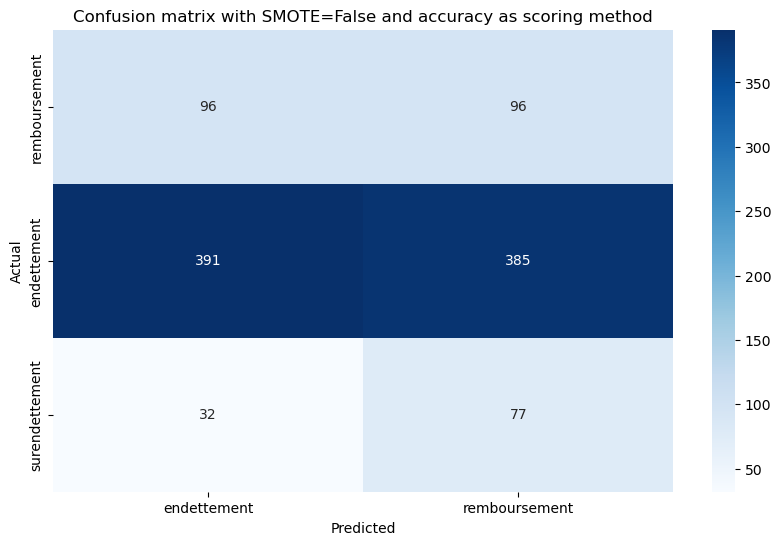

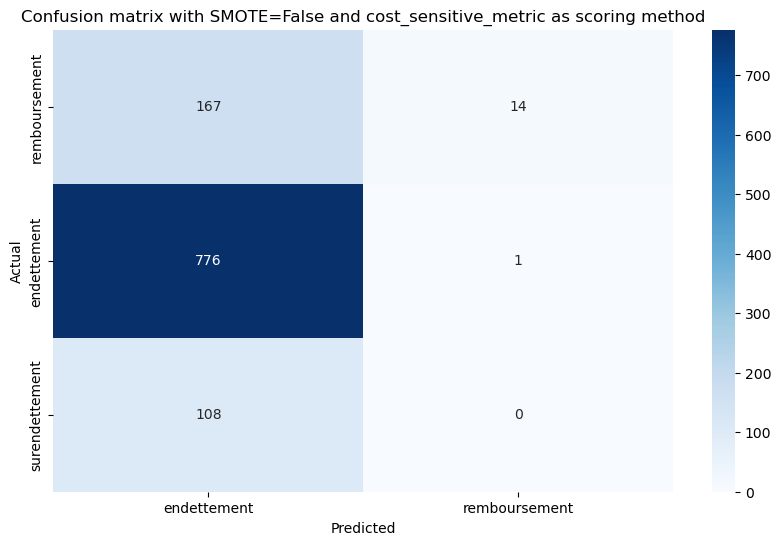

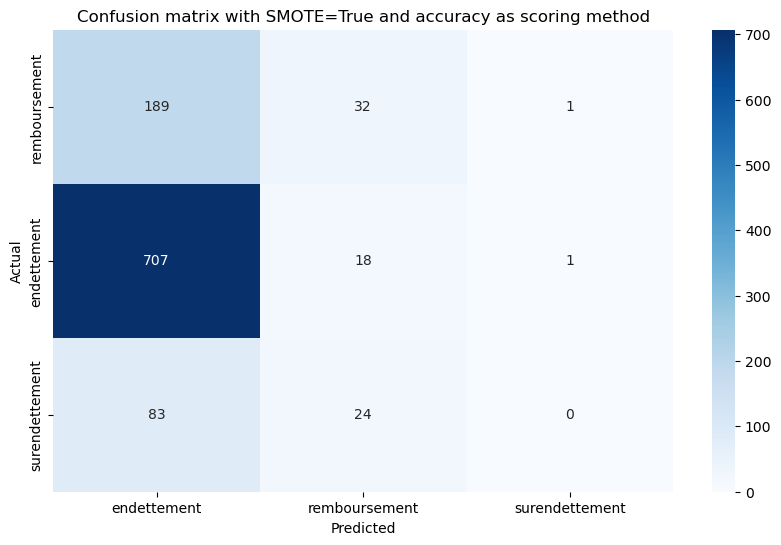

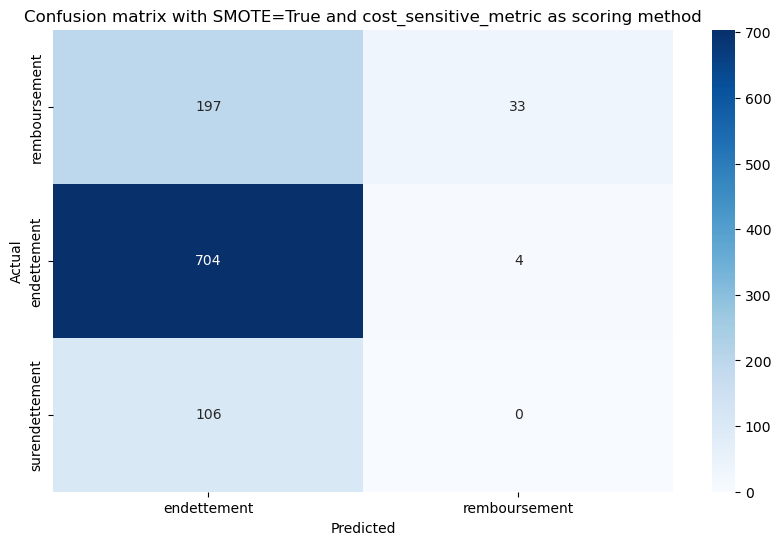

In [122]:
# Takes approximately 30 minutes to run
comparison_all_models()

It seems the best combination is not using SMOTE combined with the cost sensitive metri (to counter the imbalanced classes). We have more good predictions and less important mistakes (indebtment predicted instead of repayment). Furthermore, in that case, we have a very high precision for repayment which means that when the model predicts it, we know at a very high level of confidence that it is a true prediction and thus we're confident to invest on that movement.

This particular behavior of this model could be used : in general, the debt increases so the returns on such a position are low. But if we are able to predict for sure that the debt will be repaid at a given horizon, then because the odds are much higher, so might be the returns. Unfortunately, here we do not have enough repayment predictions to build a strategy on it.

## Trading Strategy
---
We now have a model that allows us to detect signals concerning future variations (28-day horizon) in US debt from gold data. All we need to do now is find a way to profit from it with a trading strategy. Two questions: What to trade? How to load positions?

- **US debt proxy**: check whether we can encode the slope of US debt using the ``spread of a 10y - 1y equi-std US interest rate swap`` as an instrument for our trading strategy (swap rate data available here: https://fred.stlouisfed.org/categories/32299).
- **Building a strategy based on the classification model** : 
    - We look at the signal given by the classification model to decide whether to go long or short.
    - To load positions, we can use the ‘predict_proba’ method to obtain the probabilities of our classification estimator and charge consequently the positions. 
- **Backtesting of trading strategies**: Set up a backtesting environment to evaluate the performance of trading strategies based on predictive models and on a proxy of US debt as a tradable instrument.

In [ ]:
API_KEY = "87e41f72558991abc233208c13775702" # Bad practice but necessary in this case.

series_ids = {
    "10y": "DSWP10", 
    "1y": "DSWP1",
    "3y": "DSWP3",
    "5y": "DSWP5",
}

# Base URL for FRED API
BASE_URL = "https://api.stlouisfed.org/fred/series/observations"

def fetch_swaps_data(series_id):
    """Fetch data from FRED API for a given series ID."""
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json"
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()["observations"]
        df = pd.DataFrame(data)
        df["value"] = pd.to_numeric(df["value"], errors="coerce")  
        df["date"] = pd.to_datetime(df["date"]) 
        return df[["date", "value"]]
    else:
        print(f"Error fetching data for series {series_id}: {response.status_code}")
        return pd.DataFrame()

data_1y = fetch_swaps_data(series_ids["1y"])
data_3y = fetch_swaps_data(series_ids["3y"])
data_5y = fetch_swaps_data(series_ids["5y"])
data_10y = fetch_swaps_data(series_ids["10y"])

data_frames = [data_1y, data_3y, data_5y, data_10y]
swaps_data = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames)
swaps_data.columns = ['date', '1y', '3y', '5y', '10y']
swaps_data.set_index('date', inplace=True)
swaps_data

1y    3y    5y   10y
date                              
2000-07-03  7.10  7.17  7.17  7.24
2000-07-04   NaN   NaN   NaN   NaN
2000-07-05  7.03  7.07  7.08  7.14
2000-07-06  7.07  7.14  7.16  7.21
2000-07-07  7.01  7.06  7.07  7.14
...          ...   ...   ...   ...
2016-10-24  0.99  1.15  1.30  1.61
2016-10-25  1.00  1.15  1.29  1.59
2016-10-26  1.01  1.18  1.33  1.64
2016-10-27  1.00  1.20  1.38  1.71
2016-10-28  1.00  1.19  1.36  1.71

[4260 rows x 4 columns]

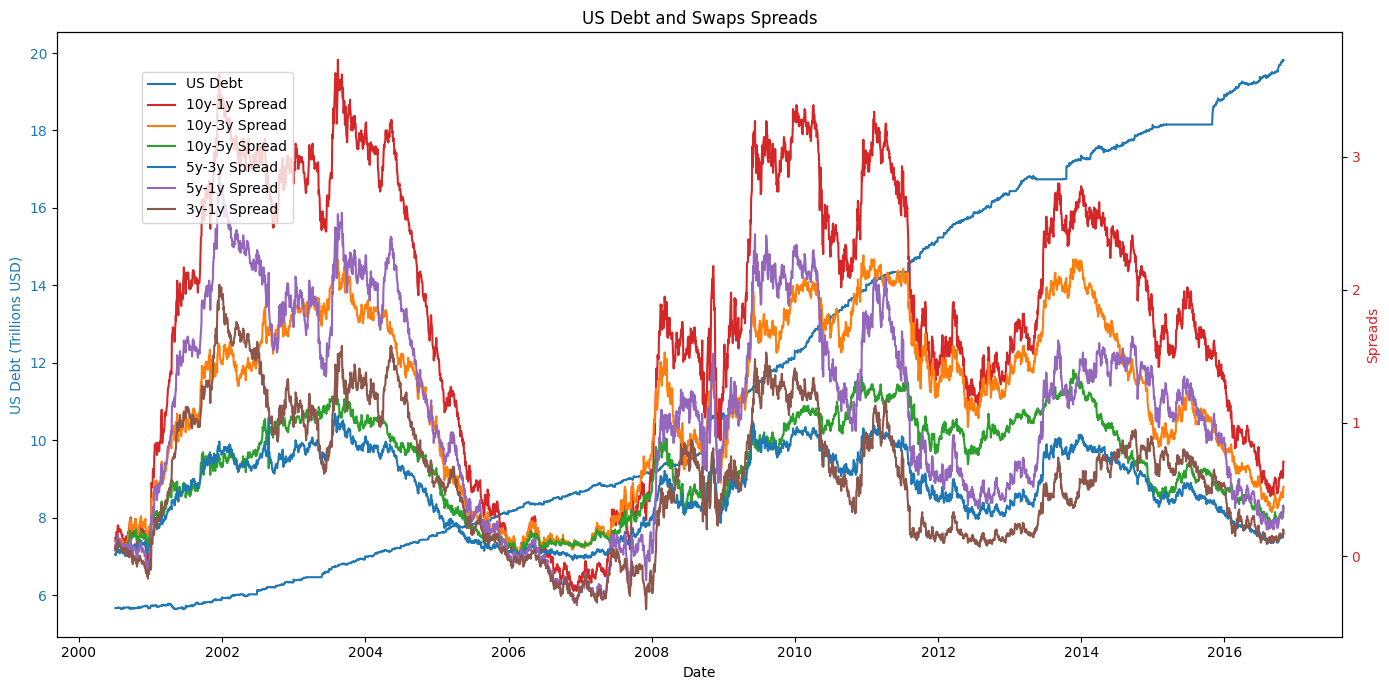

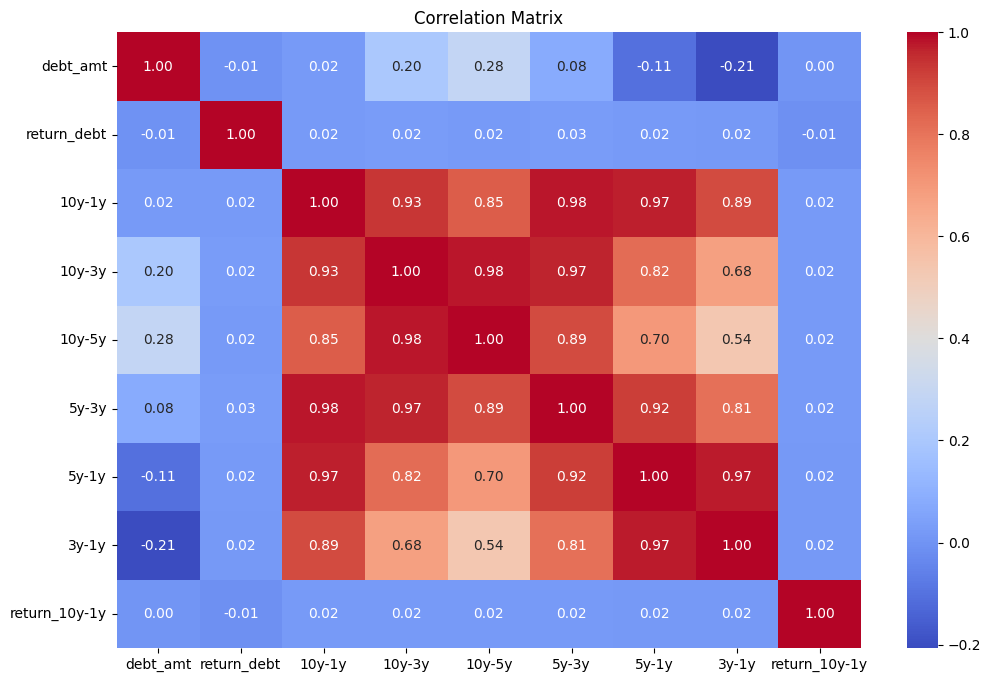

In [ ]:
# All spreads between the different swaps
spread_data = pd.DataFrame(index=swaps_data.index)
spread_data['10y-1y'] = swaps_data['10y'] - swaps_data['1y']
spread_data['10y-3y'] = swaps_data['10y'] - swaps_data['3y']
spread_data['10y-5y'] = swaps_data['10y'] - swaps_data['5y']
spread_data['5y-3y'] = swaps_data['5y'] - swaps_data['3y']
spread_data['5y-1y'] = swaps_data['5y'] - swaps_data['1y']
spread_data['3y-1y'] = swaps_data['3y'] - swaps_data['1y']


# Merge the spreads with the debt data
debt_data['return_debt'] = debt_data['debt_amt'].pct_change(1)
spread_data['return_10y-1y'] = spread_data['10y-1y'].pct_change(1)

debt_and_spreads = pd.merge(debt_data, spread_data, left_index=True, right_index=True)
debt_and_spreads.dropna(inplace=True)

# plot spread and debt data
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the debt data
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('US Debt (Trillions USD)', color=color)
ax1.plot(debt_and_spreads.index, debt_and_spreads['debt_amt'], color=color, label='US Debt')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot the spreads
ax2 = ax1.twinx()
ax2.set_ylabel('Spreads', color='tab:red')
ax2.plot(debt_and_spreads.index, debt_and_spreads['10y-1y'], color='tab:red', label='10y-1y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['10y-3y'], color='tab:orange', label='10y-3y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['10y-5y'], color='tab:green', label='10y-5y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['5y-3y'], color='tab:blue', label='5y-3y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['5y-1y'], color='tab:purple', label='5y-1y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['3y-1y'], color='tab:brown', label='3y-1y Spread')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add title and legend
plt.title('US Debt and Swaps Spreads')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

# compute correlation matrix
corr = debt_and_spreads.corr()

# plot the heatmap
plt.figure(figsize=(12, 8))
heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

As we can see, the debt return isn't strongly correlated to any spread computed above. Thus it is not possible to use our model to predict the future evolution of the US debt and then to consequently invest in swaps.

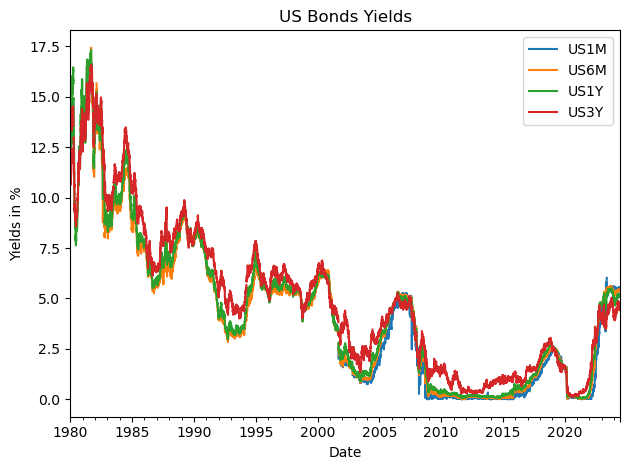

In [102]:
us_bonds[["US1M","US6M","US1Y","US3Y"]].loc["1980-01-01":].plot()
plt.title('US Bonds Yields')
plt.xlabel('Date')
plt.ylabel('Yields in %')
plt.tight_layout()
plt.legend()
plt.show()

for column in us_bonds.columns:
    us_bonds[f'{column}_delta'] = (us_bonds[column].shift(-28) - us_bonds[column]) / us_bonds[column]
    
us_bonds_target_train = us_bonds.merge(pd.DataFrame(y_train),left_index=True,right_index=True)

#{col: us_bonds_target_train["target"].corr(us_bonds_target_train[col]) for col in us_bonds_target_train.columns if col != "target"}

The same result occurs for the US Treasury yields. 

We tried multiple instruments that could be correlated to the evolution of the US debt 30 days in advance. Unfortunately, none of them were correlated enough to build an investment strategy on it. Further consideration could be to search longer for such an instrument and to check whether or not our model may allow to build a positive PnL over the years.

## Conclusion

We first conducted a very statistical approach of the relationship between gold features and US debt, computing correlations across crisis periods and then applying causality Granger tests to evaluate the predictive capacity of a time series on another one. We found out that the the gold features were more likely to give a signal on US debt than the other way around.

We managed to fit a ML model to predict future evolution of the US debt (in classes : refunding, indebtedness, over-indebtedness) at a 28 days horizon based on gold features (prices, volumes, volatility). Due to the fact that the debt is almost constantly increasing, the model is biased towards predicting indebtedness. We tried several methods to correct that bias, including building our own cost metric, by penalizing more some errors than others or to resample using SMOTE to balance the classes. We've seen that using a penalized cost metric was helping to reduce the bias but still not perfectly.

To effectively perform classification of the US debt's variation over 28 days, we might need to rethink the target (that by construction leads to imbalanced classes) or add/improve the features, for example include macro economic indicators, adjust our data to inflation or GDP, GPD/capita etc.

Finally, we explored diverse options to use as trade instruments but none of them were correlated enough with the US debt to be used with our model.